In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
batch_size = 256
img_height = 28
img_width = 28
latent_space = 3
rmse_multiplier = 7000
kl_multiplier = 1

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [7]:
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)

In [8]:
from tensorflow.keras.layers import BatchNormalization,Conv2D,Conv2DTranspose,Dense,Input,Activation,Flatten,Lambda,Reshape,Lambda 
from tensorflow.keras.models import Model
import tensorflow.keras.backend as k
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [9]:
# callbacks 
checkpoint_file = "Mnist.h5"

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=0, save_best_only=True,
                             save_weights_only=True, mode='auto')

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [10]:
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.1   
    return lr

callback_lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
class VariationalAutoEncoder():
    def __init__(self):
        self._build()
        
    def _build(self):
        
        #Encoder
        
        def sampling(args):
            mu,log_var = args
            epsilon = k.random_normal(shape = k.shape(mu),mean = 0,stddev = 1)
            return mu + k.exp(log_var/2) * epsilon
        
        image_input = Input(shape = (img_height,img_width,1), name = "vae_input")

        x_enc = Conv2D(784,(3,3),(2,2),padding = "same", name = "conv_16_31encoder")(image_input)
        x_enc = BatchNormalization(name = "batch_norm_16321_encoder")(x_enc)
        x_enc = Activation("relu",name = "activation_16412_encoder")(x_enc)

        x_enc = Conv2D(256,(3,3),(2,2),padding = "same", name = "conv4124_8_encoder")(x_enc)
        x_enc = BatchNormalization(name = "batch_norm_814124encoder")(x_enc)
        x_enc = Activation("relu",name = "activation_8_e14142ncoder")(x_enc)
        
        x_enc = Conv2D(32,(3,3),(1,1),padding = "same", name = "conv_16_4214encoder")(image_input)
        x_enc = BatchNormalization(name = "batch_norm_16_e1414ncoder")(x_enc)
        x_enc = Activation("relu",name = "activation_16_12414encoder")(x_enc)
        
        x_enc = Conv2D(4,(3,3),(1,1),padding = "same", name = "conv_1421416_encoder")(image_input)
        x_enc = BatchNormalization(name = "batch_norm_16_en14124coder")(x_enc)
        x_enc = Activation("relu",name = "activati132on_16_enc1414oder")(x_enc)

        x_enc = Flatten(name = "flatten_encoder")(x_enc)
        self.mu = Dense(latent_space, activation = "linear",name = "mu")(x_enc)
        self.log_var = Dense(latent_space, activation = "linear", name = "log_var")(x_enc)

        encoder_output = Lambda(sampling, name = "encoder_output")([self.mu,self.log_var])        

        self.encoder = Model(inputs = [image_input], outputs = [encoder_output])
        
        #Decoder
        
        latent_space_input = Input(shape=(latent_space,), name = "decoder_input")

        x_dec = Dense(3136, activation = "linear",name = "decoder_dense")(latent_space_input)
        x_dec = Reshape(target_shape = (7,7,64)) (x_dec)

        x_dec = Conv2DTranspose(784,(3,3),(1,1),padding = "same", name = "conv_13123213_decoder")(x_dec)
        x_dec = BatchNormalization(name = "batch_norm13213_164_decoder")(x_dec)
        x_dec = Activation("relu",name = "activation_31231664_decoder")(x_dec)
        
        x_dec = Conv2DTranspose(256,(3,3),(1,1),padding = "same", name = "conv_1k_3123decoder")(x_dec)
        x_dec = BatchNormalization(name = "batch_norm23123_1k_decoder")(x_dec)
        x_dec = Activation("relu",name = "activation_131231y6_decoder")(x_dec)
                       
        x_dec = Conv2DTranspose(32,(3,3),(2,2),padding = "same", name = "conv_13_31decoder")(x_dec)
        x_dec = BatchNormalization(name = "batch_nor31231m_164_decoder")(x_dec)
        x_dec = Activation("relu",name = "activation_12311664_decoder")(x_dec)
                       
        
        x_dec = Conv2DTranspose(4,(3,3),(2,2),padding = "same", name = "conv_13_de231coder")(x_dec)
        x_dec = BatchNormalization(name = "batch_nor13213m_164_decoder")(x_dec)
        x_dec = Activation("relu",name = "activation_13213664_decoder")(x_dec)

        x_dec = Conv2DTranspose(1,(3,3),(1,1),padding = "same", name = "conv_33123_decoder")(x_dec)
        x_dec = BatchNormalization(name = "batch_norm_3_decoder")(x_dec)
        decoder_output = Activation("sigmoid",name = "activation_3_decoder")(x_dec)       
 
        self.decoder = Model(inputs = [latent_space_input], outputs = [decoder_output])
        
        
        #Variational AutoEncoder
        
        model_input = image_input
        model_output = self.decoder(encoder_output)

        self.full_model = Model(model_input, model_output)
        
    def custom_compile(self, learning_rate, rmse_multiplier):
        self.learning_rate = learning_rate
       
        def vae_r_loss(y_true, y_pred):
            r_loss = k.mean(k.square(y_true - y_pred), axis = [1])
            return rmse_multiplier * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  - 0.5 * k.sum(1 + self.log_var - k.square(self.mu) - k.exp(self.log_var), axis = 1)
            return kl_loss * kl_multiplier 

        def vae_loss(y_true, y_pred):
            reconstruction_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  reconstruction_loss + kl_loss 

        optimizer = Adam(learning_rate=learning_rate)
        self.full_model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss,vae_kl_loss]) 
       

In [11]:
estimator = VariationalAutoEncoder()

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
estimator.custom_compile(learning_rate = 0.001, rmse_multiplier = rmse_multiplier)

In [13]:
estimator.full_model.fit(x_train,x_train,validation_data = (x_test,x_test), epochs = 100, callbacks = [checkpoint,early,callback_lr_decay])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
59968/60000 [============================>.] - ETA: 0s - loss: 517.8396 - vae_r_loss: 505.4763 - vae_kl_loss: 12.3629

C:\Users\gonzalo\.conda\envs\generative_pokemon\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 50s 828us/sample - loss: 517.8323 - vae_r_loss: 505.4701 - vae_kl_loss: 12.3618 - val_loss: 440.8633 - val_vae_r_loss: 429.7617 - val_vae_kl_loss: 11.1015 - lr: 1.0000e-04
Epoch 2/100
60000/60000 [==============================] - 47s 787us/sample - loss: 379.7443 - vae_r_loss: 369.0792 - vae_kl_loss: 10.6652 - val_loss: 334.5122 - val_vae_r_loss: 324.1799 - val_vae_kl_loss: 10.3323 - lr: 1.0000e-04
Epoch 3/100
60000/60000 [==============================] - 48s 794us/sample - loss: 309.3577 - vae_r_loss: 299.0312 - vae_kl_loss: 10.3267 - val_loss: 279.6991 - val_vae_r_loss: 269.7398 - val_vae_kl_loss: 9.9592 - lr: 1.0000e-04
Epoch 4/100
60000/60000 [==============================] - 48s 801us/sample - loss: 265.1128 - vae_r_loss: 254.8667 - vae_kl_loss: 10.2460 - val_loss: 245.7666 - val_vae_r_loss: 235.7107 - val_vae_kl_loss: 10.0559 - lr: 1.0000e-04
Epoch 5/100
60000/60000 [==============================] - 48s 806us/sample - loss: 236.4

In [12]:
import random
num = random.randint(0,9999)

In [97]:
latent = estimator.encoder.predict(np.expand_dims(x_test[num],axis = 0))

In [98]:
reconstruction = estimator.decoder.predict(latent)

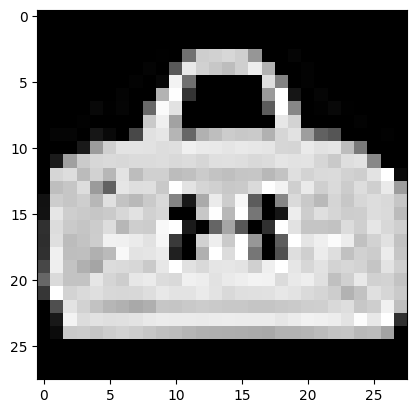

In [16]:
plt.imshow(x_test[num],cmap = "gray")

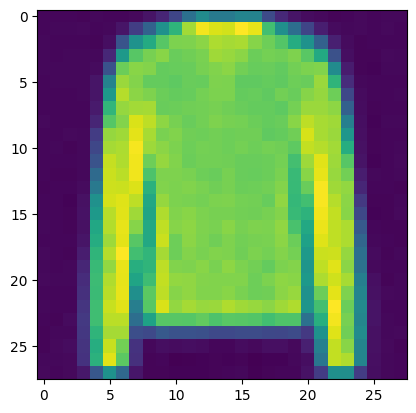

In [100]:
plt.imshow(reconstruction[0],cmap = "gray")

In [69]:
generation = estimator.decoder.predict(np.random.normal(size = (1,latent_space)))

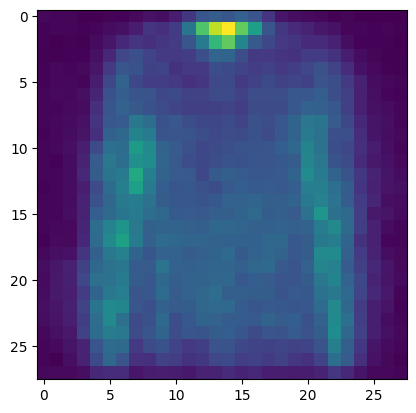

In [70]:
plt.imshow(generation[0],cmap = "gray")

In [21]:
import pandas as pd

In [22]:
complete_latent_space = estimator.encoder.predict(x_test)

In [23]:
graphDf = pd.DataFrame(data = complete_latent_space
             , columns = ['z1', 'z2','z3'])
graphDf = pd.concat([graphDf, pd.DataFrame(y_test)], axis = 1)

In [24]:
graphDf.rename(columns = {0 : "class"},inplace = True)

In [25]:
class_dict = {
0:"T-shirt/top",
1:"Trouser",
2:"Pullover",
3:"Dress",
4:"Coat",
5:"Sandal",
6:"Shirt",
7:"Sneaker",
8:"Bag",
9:"Ankle boot",
}

In [26]:
graphDf["class"].replace(to_replace = class_dict, inplace = True)

In [27]:
import plotly.express as px
df = graphDf
fig = px.scatter_3d(df, x='z1', y='z2', z='z3',
              color="class")
fig.write_html('LatentSpace.html', auto_open=True)

In [28]:
adasda = np.expand_dims(np.array([-0.3,-2,-0.5]),axis = 0)

In [29]:
generation = estimator.decoder.predict(adasda)

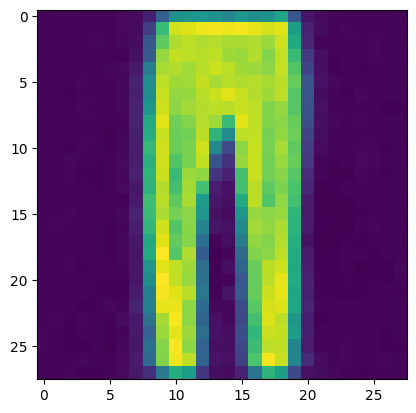

In [30]:
plt.imshow(generation[0],cmap = "gray")